# This notebook started from John Bart's notebook of example code showing how to read the audio clip data using the librosa.

I changed this to read the "one_week" recording. 

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 10

import numpy as np

import librosa
import librosa.display

import aco
from aco import ACOio, datetime, timedelta, Mp3Loader

# dir containing sound files
srcdir = './one_week'

## Read clip paths from recording folder
### Parses date/time for each clip
### Sorts clips by time

In [2]:
import os
import fnmatch
from datetime import datetime,timedelta  
import IPython.display as ipd


def read_clipnames(srcdir):
    """Walk through base folder and collect paths for all sound files.
        parse date and time info, sort, and return as a dataframe"""
    
    clipexts=['*.mp3']
    datefmt='%Y-%m-%d--%H.%M.mp3'

    # search through source folder for sound files
    # save clip path and date (parsed from filename)
    clippath = []
    clipdate = []
    for ext in clipexts:
        for root, dirnames, filenames in os.walk(srcdir):
            for filename in fnmatch.filter(filenames, ext):
                clippath.append(os.path.join(root, filename).replace('\\','/'))
                clipdate.append(datetime.strptime(filename, datefmt))
                
    # get sort index
    idx = np.argsort(clipdate)
    # retun sorted dataframe
    return pd.DataFrame({'date': np.array(clipdate)[idx], 
                       'path':  np.array(clippath)[idx]})  
df = read_clipnames(srcdir)

## Read audio data and plot spectrographs and waveforms of several clips¶


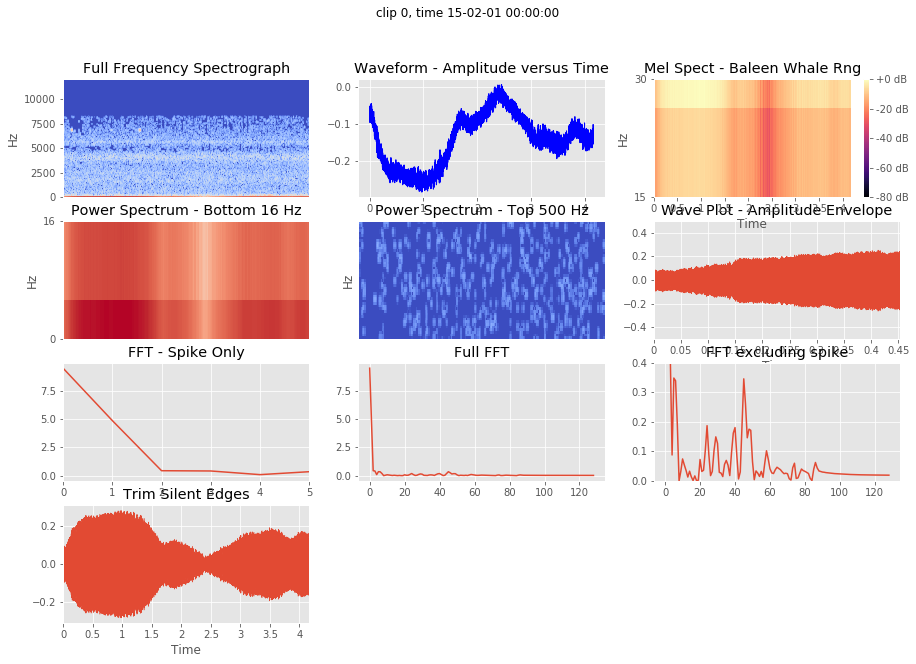

In [58]:
numclips = 1
hoplength=None
fftsize=256
numsamps=100000
n_mels = 256
n_mels2 = 64

# read and plot some sound clips
for i, (dt, path) in df.iloc[:numclips].iterrows():
    # convert mp3 to audio samples
    y, sr = librosa.load(path, sr=None)
    y = y[:numsamps]

    # abs date-time of each sample (disable - takes to long)
    #x = [dt+timedelta(seconds=t) for t in np.arange(0,len(y))/sr]

    # time of each sample (seconds rel to clip start)
    x = np.arange(0,len(y))/sr
    
    # calc spectrograph
    D = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
    
    # Pre-compute a global reference power from the input spectrum
    rp = np.max(np.abs(D))
    
    ipd.Audio(path)

    plt.figure(figsize=(15,10))
    plt.suptitle('clip %d, time %s'%(i, dt.strftime('%y-%m-%d %H:%M:00')))

    # display spectrograph
    plt.subplot(4,3,1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),ref=rp), 
                             sr=sr, y_axis='linear',cmap='coolwarm')
    plt.title('Full Frequency Spectrograph')
    
    # plot waveform
    plt.subplot(4,3,2)
    plt.plot(x, y, 'b-', linewidth=1)
    plt.title('Waveform - Amplitude versus Time')
      
    # plot low Frequency power spectrum
    plt.subplot(4,3,4)
    D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D2, y_axis='log',cmap='coolwarm')
    plt.ylim(0, 16)
    plt.title('Power Spectrum - Bottom 16 Hz')
     
    # plot High Frequency power spectrum
    plt.subplot(4,3,5)
    D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D2, y_axis='log',cmap='coolwarm')
    plt.ylim(7000, 7500)
    plt.title('Power Spectrum - Top 500 Hz')
    
    # plot waveplot
    plt.subplot(4,3,6)
    librosa.display.waveplot(y[:10000],cmap='coolwarm')
    plt.ylim(-0.5, 0.5)
    plt.title('Wave Plot - Amplitude Envelope')

    # trim silent edges
    plt.subplot(4,3,10)
    plt.title('Trim Silent Edges')
    trimmed_silences, _ = librosa.effects.trim(y)
    librosa.display.waveplot(trimmed_silences, sr=sr);
    
    plt.subplot(4,3,9)
    D = np.abs(librosa.stft(trimmed_silences[:fftsize], n_fft=fftsize, hop_length=fftsize+1))
    plt.ylim(0, .4)
    plt.title('FFT excluding spike')
    plt.plot(D);
   
    plt.subplot(4,3,8)
    D2 = np.abs(librosa.stft(trimmed_silences[:fftsize], n_fft=fftsize, hop_length=fftsize+1))
    plt.title('Full FFT')
    plt.plot(D2);
    
    plt.subplot(4, 3, 3)
    S = librosa.feature.melspectrogram(trimmed_silences, sr=sr, n_fft=fftsize, 
                                       hop_length=fftsize+1, 
                                       n_mels=n_mels2)

    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=fftsize+1, 
                             x_axis='time', y_axis='mel');
    plt.ylim(15, 30)
    plt.title('Mel Spect - Baleen Whale Rng');
    plt.colorbar(format='%+2.0f dB');
    
    plt.subplot(4,3, 7)
    D2 = np.abs(librosa.stft(trimmed_silences[:fftsize], n_fft=fftsize, hop_length=fftsize+1))
    plt.xlim(0, 5)
    plt.title('FFT - Spike Only')
    plt.plot(D2);
 
    

## Here is my trip down Alice's hole - Oh well

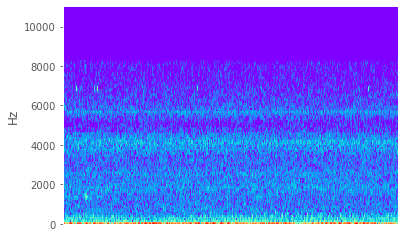

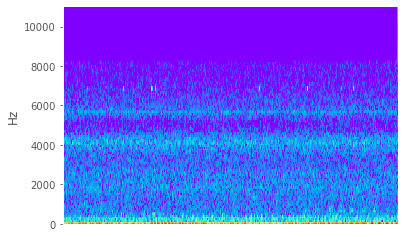

In [25]:
# Create Spectrogram and then filter out noise. Then you can start looking for vocalizations with notch filters
## Read clip paths from recording folder## Read clip paths from recording folder
numclips = 2
hoplength=None
fftsize=256
numsamps=100000

# read and plot some sound clips
for i, (dt, path) in df.iloc[:numclips].iterrows():
    
     # time of each sample (seconds rel to clip start)
    x = np.arange(0,len(y))/sr
    
    # calc spectrograph
    clip_stft = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
    
    # Pre-compute a global reference power from the input spectrum
    rp = np.max(np.abs(clip_stft))
    
    filename = path
    y, sr = librosa.load(filename)
    
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(clip_stft),ref=rp),sr=sr, y_axis='linear', cmap='rainbow')
    

In [5]:
type(clip_stft)

numpy.ndarray

In [17]:
print("clip_stft ndim: ", D.ndim)
print("clip_stft shape:", D.shape)
print("clip_stft size: ", D.size)

clip_stft ndim:  2
clip_stft shape: (129, 1)
clip_stft size:  129


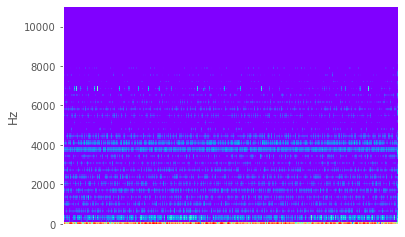

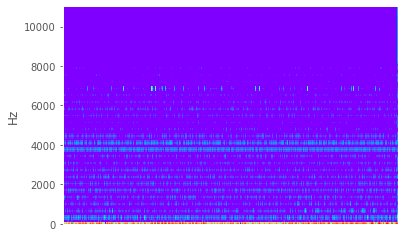

In [26]:
from scipy import signal

sf = 44100
t = np.arange(0., 0.5+1./sf, 1./sf)

# read and plot some sound clips
for i, (dt, path) in df.iloc[:numclips].iterrows():
    
     # time of each sample (seconds rel to clip start)
    x = np.arange(0,len(y))/sr
    
    # calc spectrograph
    clip_stft = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
    
    # Pre-compute a global reference power from the input spectrum
    rp = np.max(np.abs(clip_stft))
    
    filename = path
    y, sr = librosa.load(filename)
    
    #Make a Butterworth Filter
    N  = 6    # Filter order
    fc = 1/16 # Cutoff frequency, normalized 
    b, a = signal.butter(N, fc)

    #Apply the filter
    filtered_stft = signal.filtfilt(b,a, clip_stft)
    
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(filtered_stft),ref=rp),sr=sr, y_axis='linear', cmap='rainbow')
    


<Figure size 1080x720 with 0 Axes>

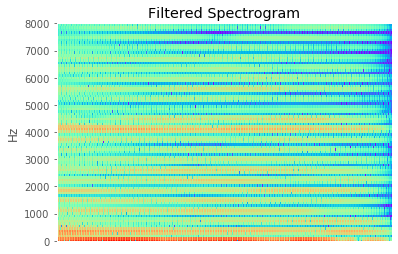

<Figure size 1080x720 with 0 Axes>

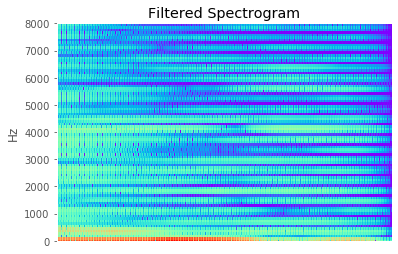

<Figure size 1080x720 with 0 Axes>

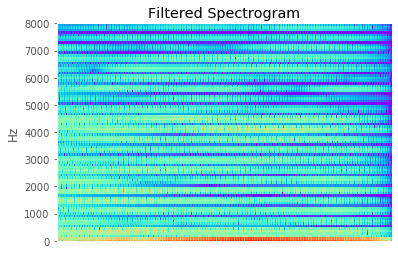

<Figure size 1080x720 with 0 Axes>

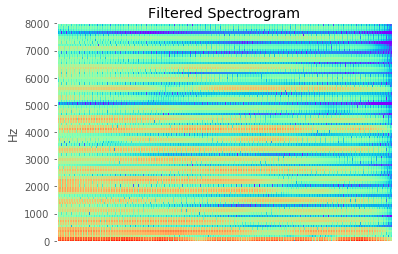

<Figure size 1080x720 with 0 Axes>

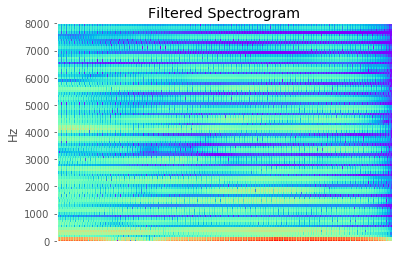

In [66]:
numclips = 5
hoplength=None
fftsize=256
numsamps=100000

#Filter parameters
f0 = 1000.0  # Frequency I  want to keep
Q = 30.0  # Quality factor

# Make a notch filter
b, a = signal.iirpeak(f0, Q, sr)

# read and plot some sound clips
for i, (dt, path) in df.iloc[:numclips].iterrows():
    # convert mp3 to audio samples
    y, sr = librosa.load(path, sr=None)
    y = y[:numsamps]

    # abs date-time of each sample (disable - takes to long)
    #x = [dt+timedelta(seconds=t) for t in np.arange(0,len(y))/sr]

    # time of each sample (seconds rel to clip start)
    x = np.arange(0,len(y))/sr
    
    # calc spectrograph
    D = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
    
    # Pre-compute a global reference power from the input spectrum
    rp = np.max(np.abs(D))
    
    ipd.Audio(path)

    plt.figure(figsize=(15,10))
    plt.suptitle('clip %d, time %s'%(i, dt.strftime('%y-%m-%d %H:%M:00')))

    #Apply the filter
    filtered_stft = signal.filtfilt(b,a, D)
    
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(filtered_stft),ref=rp),sr=sr, y_axis='linear', cmap='rainbow')
    plt.ylim(0, 8000)
    plt.title('Filtered Spectrogram')

## Look at John's real vocalizations

In [80]:
John_file_loc = 'D:\targets'
filename = John_file_loc+'\1900B,hbw,00 00 00.wav'
y, sr = librosa.load(filename)
D = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)


OSError: [Errno 22] Invalid argument: 'D:\targets\x01900B,hbw,00 00 00.wav'